<a href="https://colab.research.google.com/github/ahmedyasser7/DEPI_GP/blob/main/ACCIDENT_SEVERITY_PREDICTIVE_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ACCIDENT SEVERITY PREDICTIVE MODEL**

# Uploading The Dataset



In [ ]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload the file

Saving accident cleaned data.csv to accident cleaned data (1).csv


# Importing Libraries

In [ ]:
# Importing the necessary Libraries
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


#Loading the Data

In [ ]:
# Load the 'accident cleaned data.csv' dataset
df =  pd.read_csv('/content/accident cleaned data.csv')

# Check the first few rows
df.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Urban_or_Rural_Area
0,200901BS70001,-0.201349,51.512273,2,2,1,2009-01-01,5,15:11:00,12,E09000020,30,1,1,1,0,1
1,200901BS70002,-0.199248,51.514399,2,2,11,2009-01-05,2,10:59:00,12,E09000020,30,1,1,2,0,1
2,200901BS70003,-0.179599,51.486668,3,2,1,2009-01-04,1,14:19:00,12,E09000020,30,1,1,1,0,1
3,200901BS70004,-0.203110,51.507804,2,2,1,2009-01-05,2,08:10:00,12,E09000020,30,1,8,4,0,1
4,200901BS70005,-0.173445,51.482076,2,2,1,2009-01-06,3,17:25:00,12,E09000020,30,4,1,1,0,1


#Exploring & Preprocessing the Data

In [ ]:
# Check for missing values
df.isnull().sum()

,0
Accident_Index,0
Longitude,0
Latitude,0
Accident_Severity,0
Number_of_Vehicles,0
Number_of_Casualties,0
Date,0
Day_of_Week,0
Time,0
Local_Authority_(District),0


In [ ]:
# Check for duplicate values
df.duplicated().sum()

0

In [ ]:
print(df.shape)

(898555, 17)


In [ ]:
# Get information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898555 entries, 0 to 898554
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Accident_Index              898555 non-null  object 
 1   Longitude                   898555 non-null  float64
 2   Latitude                    898555 non-null  float64
 3   Accident_Severity           898555 non-null  int64  
 4   Number_of_Vehicles          898555 non-null  int64  
 5   Number_of_Casualties        898555 non-null  int64  
 6   Date                        898555 non-null  object 
 7   Day_of_Week                 898555 non-null  int64  
 8   Time                        898555 non-null  object 
 9   Local_Authority_(District)  898555 non-null  int64  
 10  Local_Authority_(Highway)   898555 non-null  object 
 11  Speed_limit                 898555 non-null  int64  
 12  Light_Conditions            898555 non-null  int64  
 13  Weather_Condit

we will:
- drop (Accident_Index, Date, Time) as they don't contribute to predicting "Accident Severity".
- Keep all the other columns.
- Encode categorical columns like Local_Authority_(Highway) using One-Hot Encoding.


## Drop Irrelevant Columns

In [ ]:
# Drop irrelevant columns
df = df.drop(['Accident_Index', 'Date', 'Time'], axis=1)

## Handle Categorical Variables

In [ ]:
# Identify object (categorical) columns
categorical_cols = df.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['Local_Authority_(Highway)'], dtype='object')


In [ ]:
# Apply one-hot encoding to categorical columns
df = pd.get_dummies(df, columns=['Local_Authority_(Highway)'], drop_first=True)

## Check for Numeric Features

In [ ]:
# Check if all features are numeric
print(df.dtypes)

Longitude                              float64
Latitude                               float64
Accident_Severity                        int64
Number_of_Vehicles                       int64
Number_of_Casualties                     int64
                                        ...   
Local_Authority_(Highway)_W06000020       bool
Local_Authority_(Highway)_W06000021       bool
Local_Authority_(Highway)_W06000022       bool
Local_Authority_(Highway)_W06000023       bool
Local_Authority_(Highway)_W06000024       bool
Length: 219, dtype: object


In [ ]:
# Convert boolean columns to integers (0 and 1)
df = df.astype(int)

In [ ]:
# Check the data types after conversion
print(df.dtypes)

Longitude                              int64
Latitude                               int64
Accident_Severity                      int64
Number_of_Vehicles                     int64
Number_of_Casualties                   int64
                                       ...  
Local_Authority_(Highway)_W06000020    int64
Local_Authority_(Highway)_W06000021    int64
Local_Authority_(Highway)_W06000022    int64
Local_Authority_(Highway)_W06000023    int64
Local_Authority_(Highway)_W06000024    int64
Length: 219, dtype: object


## Handling Class Imbalance


In [ ]:
accident_severity_counts = df['Accident_Severity'].value_counts()
accident_severity_counts

,count
Accident_Severity,
3,763607
2,124471
1,10477


In [ ]:
# Combine the majority and minority classes
df_majority = df[df['Accident_Severity'] == 3]  # '3' is the majority class
df_minority_1 = df[df['Accident_Severity'] == 1]  # '1' is a minority class
df_minority_2 = df[df['Accident_Severity'] == 2]  # '2' is a minority class

# Under-sample majority class
df_majority_undersampled = df_majority.sample(len(df_minority_1) + len(df_minority_2), random_state=42)

# Combine back to one DataFrame
df_balanced = pd.concat([df_majority_undersampled, df_minority_1, df_minority_2])

## Feature Scaling

In [ ]:
# Features to scale (excluding the target variable 'Accident_Severity')
features_to_scale = df_balanced.drop('Accident_Severity', axis=1)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the features and transform them
scaled_features = scaler.fit_transform(features_to_scale)

# Create a DataFrame with scaled features
df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# Add the target variable back to the scaled DataFrame
df_scaled['Accident_Severity'] = df_balanced['Accident_Severity'].values

# Display the first few rows of the scaled DataFrame
df_scaled.head()

,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,...,Local_Authority_(Highway)_W06000015,Local_Authority_(Highway)_W06000016,Local_Authority_(Highway)_W06000018,Local_Authority_(Highway)_W06000019,Local_Authority_(Highway)_W06000020,Local_Authority_(Highway)_W06000021,Local_Authority_(Highway)_W06000022,Local_Authority_(Highway)_W06000023,Local_Authority_(Highway)_W06000024,Accident_Severity
0,-0.719804,0.630885,0.307198,0.615919,0.454743,-0.983929,-0.666030,-0.594055,-0.335417,-0.568783,...,-0.062435,-0.052185,-0.038429,-0.026751,-0.026751,-0.033965,-0.042033,-0.05984,-0.02619,3
1,0.082198,-0.042553,-1.027202,-0.394377,1.481070,-0.417252,1.431791,-0.594055,-0.335417,-0.568783,...,-0.062435,-0.052185,-0.038429,-0.026751,-0.026751,-0.033965,-0.042033,-0.05984,-0.02619,3
2,0.082198,-1.389428,0.307198,-0.394377,-0.571584,1.068362,-0.666030,-0.594055,-0.335417,-0.568783,...,-0.062435,-0.052185,-0.038429,-0.026751,-0.026751,-0.033965,-0.042033,-0.05984,-0.02619,3
3,0.082198,1.304322,0.307198,-0.394377,-0.571584,-0.819287,0.732518,1.171073,-0.335417,-0.568783,...,-0.062435,-0.052185,-0.038429,-0.026751,-0.026751,-0.033965,-0.042033,-0.05984,-0.02619,3
4,-0.719804,0.630885,0.307198,-0.394377,-1.597911,-0.995416,-1.365303,1.171073,-0.335417,1.000438,...,-0.062435,-0.052185,-0.038429,-0.026751,-0.026751,-0.033965,-0.042033,-0.05984,-0.02619,3


# Model Selection & Training


## Train-Test Split

In [ ]:
# Define the feature set (X) and target variable (y)
X = df_scaled.drop('Accident_Severity', axis=1)
y = df_scaled['Accident_Severity']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Initialize Models and Hyperparameters

In [ ]:
models = {
    'Decision Tree': (DecisionTreeClassifier(max_depth=10, min_samples_split=10), {})
}


## Define the Evaluation Functions

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
# Function to generate confusion matrix
def generate_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return cm

In [ ]:
# Function to generate classification report
def generate_classification_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report

## Perform Randomized Search CV for the Model

Training Decision Tree with Randomized Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best cross-validated accuracy for Decision Tree: 0.5824
Decision Tree Accuracy: 0.5840
Classification Report for Decision Tree:
               precision    recall  f1-score       support
1              0.086957  0.001909  0.003737   2095.000000
2              0.564220  0.542599  0.553198  24895.000000
3              0.600573  0.667395  0.632224  26990.000000
accuracy       0.584013  0.584013  0.584013      0.584013
macro avg      0.417250  0.403968  0.396386  53980.000000
weighted avg   0.563874  0.584013  0.571386  53980.000000
Decision Tree Confusion Matrix:
[[    4  1472   619]
 [   26 13508 11361]
 [   16  8961 18013]]


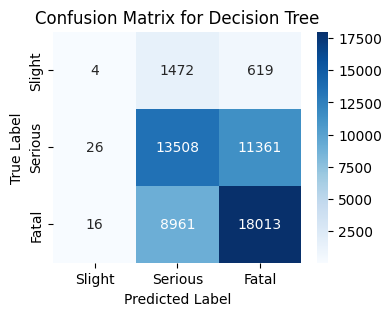

In [ ]:
# Adjusting the target variable to start from 0
df['Accident_Severity'] = df['Accident_Severity'] - 1

# Initialize dictionaries to store evaluation results
evaluation_results = {}

# Randomized Search for the model
for model_name, (model, params) in models.items():
    print(f"Training {model_name} with Randomized Search...")

    # Initialize RandomizedSearchCV
    randomized_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=20,
                                           cv=3, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

    # Fit Randomized Search
    randomized_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_
    print(f"Best cross-validated accuracy for {model_name}: {best_score:.4f}")

    # Evaluate the best model
    best_model = randomized_search.best_estimator_

    # Calculate accuracy using the helper function
    accuracy = calculate_accuracy(best_model, X_test, y_test)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Generate classification report
    classification_report_dict = generate_classification_report(best_model, X_test, y_test)
    print(f"Classification Report for {model_name}:\n", pd.DataFrame(classification_report_dict).T)

    # Calculate and print the confusion matrix using the helper function
    cm = generate_confusion_matrix(best_model, X_test, y_test)
    print(f"{model_name} Confusion Matrix:\n{cm}")

    # Plot the confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Slight', 'Serious', 'Fatal'],
                yticklabels=['Slight', 'Serious', 'Fatal'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Store evaluation results in the dictionary
    evaluation_results[model_name] = {
        'accuracy': accuracy,
        'best_params': best_params,
    }


#Save the Model

In [ ]:
import pickle

# Assuming 'model' is your trained classification model
with open('classification_model.pkl', 'wb') as file:
    pickle.dump(model, file)
